# Ensemble Learning

**Ensemble learning** is usually really powerful for classification problems and tends to perform better than its singular components.

## Learning with ensembles

What we are going to do is to combine different classifiers into a meta classifier that performs better than anyone of its components. Here we will focus on **majority voting** meaning that we will select the class that has been chosen by the absolute majority of classifiers.

While majority voting refers to binary classifiers, we can extend the method to multiclass problems with **plurality voting** which is going to select the label based on simple majority (mode).

Ensemble methods work better than simple classifiers because we *combine* the classifications from every one of them making errors more unlikely. We can use combinatorics to show how it works:

$$
P(y \geq k)=\sum_{k}^{n}{n \choose k}\varepsilon^{k}(1-\varepsilon)^{n-k}=\varepsilon_{ensemble}
$$

${n \choose k}$ is the binomial coefficient *n choose k*, so what we basically do is compute the probability that the prediction of the ensemble is wrong. Below an example with 11 base classifiers ($n=11$) with an error rate of 0.25 ($\varepsilon=0.25$):

$$
P(y \geq k)=\sum_{k=6}^{11}{11 \choose k}0.25^{k}(1-\varepsilon)^{11-k}=0.034
$$

As we can see the error rate of the ensemble is much lower than the error rate of any individual classifier. To compare an ensemble classifier to a base classifier let's implement the probability mass function in Python

In [10]:
from scipy.misc import comb
import math

In [11]:
def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0)
    probs = [comb(n_classifier, k) * error**k * (1 - error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [12]:
ensemble_error(11, 0.25)

0.034327507019042969

Now we can visualize the relationship between ensemble and base errors from 0.0 to 1.0

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 7.0)

In [14]:
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(11, error) for error in error_range]

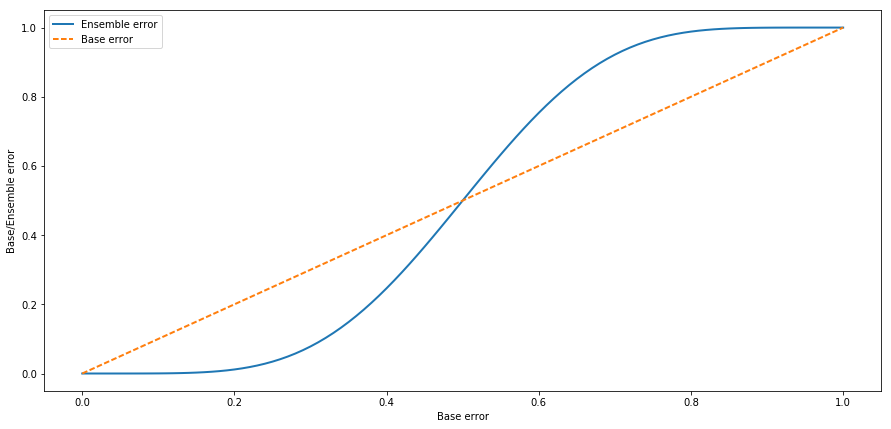

In [15]:
plt.plot(error_range, ens_errors,
         label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, 
         linestyle='--', label='Base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.show()

As we can see in the plot above the ensemble will always perform better than the base classifier as long as the error of the base classifier is better than random guessing (50-50).

## Implementing a majority voting classifier

Our goal is to build a meta-classifier that balances out the individual classifiers' weaknesses. In mathematical terms we can write the weighted majority vote as:

$$
\hat{y}=arg max_{i}\sum_{j=1}^{m}w_{j}\chi_{A}(C_{j}(x)=i)
$$

Here $w_j$ is a weight associated with a base classifier $C_j$, $\hat{y}$ is the predicted class label of the ensemble, $\chi_{A}$ is the characteristic function $[C_j(x)=i\in A]$ and $A$ is the set of unique class labels.

For equal weights we can simplify this equation as:

$$
\hat{y}=mode\{C_1(x),C_2(x),...,C_m(x)\}
$$

Let's see a concrete example, if we have en ensemble of three classifiers $C_j(j \in {0,1})$ and want to predict the class label of a given sample instance $x$. Two out of three predict class 0, and one predicts class 1. If we weight the predictions of each base classifier equally what we have is a simple majority voting:

$$
\hat{y}=mode\{0,0,1\}=0
$$

Now let's assign a weight of 0.6 to $C_3$ and weight $C_1$ and $C_2$ by a coefficient of 0.2.

$$
arg max_i[0.2 \times i_0 + 0.2 \times i_0 + 0.6 \times i_1]=1
$$

Since $3 \times 0.2 = 0.6$, we can say that the prediction made by $C_3$ has three times more weight than the others. We can write this as follows:

$$
\hat{y}=mode\{0,0,1,1,1\}=1
$$

To translate this concept in Python we can use NumPy's [**argmax**](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) and [**bincount**](https://docs.scipy.org/doc/numpy/reference/generated/numpy.bincount.html) functions.

In [16]:
import numpy as np

np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

Certain classifiers can also return the probability of a predicted class via the [**predict_proba**](http://scikit-learn.org/stable/modules/generated/sklearn.svm.libsvm.predict_proba.html) method. Using the predicted probabilities instead of class labels can be useful for majority voting.

$$
\hat{y}=argmax_i \sum_{j=1}^{m}w_j p_{ij}
$$

Here $p_{ij}$ is the predicted probability of the jth classifier for class label i. Let's go back to our previous example with three classifiers, let's assume that classifier $C_j$ returns the following class probabilities:

$$
C_1(x)\rightarrow[0.9,0.1],C_2(x)\rightarrow[0.8,0.2],C_3(x)\rightarrow[0.4,0.6]
$$

We can then calculate the individual class probabilities as follows:

$$
p(i_0|x)=0.2\times0.9+0.2\times0.8+0.6\times0.4=0.58
$$

$$
p(i_0|x)=0.2\times0.1+0.2\times0.2+0.6\times0.06=0.42
$$

$$
\hat{y}=argmax_i[p(i_0|x),p(i_1|x)]=0
$$

To implement the weightd majority vote based on class probabilities we can make use of NumPy's [**average**](https://docs.scipy.org/doc/numpy/reference/generated/numpy.average.html) and **argmax** functions.

In [17]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
print(p)
np.argmax(p)

[ 0.58  0.42]


0

Putting everything together let's implement a **MajorityVoteClassifier** in Python

In [18]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """A majority vote ensemble classifier
    
    Parameters
    -----------
    classifiers: array-like, shape = [n_classifiers]
        Different classifiers for the ensemble
    
    vote: str, {'classlabel', 'probability'} (default='label')
        If 'classlabel' the prediction is based on the argmax of
            class labels. Else if 'probability', the argmax of 
            the sum of probabilities is used to predict the class 
            label (recommended for calibrated classifiers).
    
    weights: array-like, shape = [n_classifiers], optional (default=None)
        If a list of 'int' or 'float' values are provided, the classifiers
            are weighted by importance; uses uniform weights if 'weights=None'
    
    """
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value 
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    
    def fit(self, x, y):
        """Fit classifiers.
        
        Parameters
        -----------
        x: {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples
            
        y: array-like, shape = [n_samples]
            Vector of target class labels.
            
        Returns
        --------
        self: object
        
        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)" % self.vote)
        
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError("Number of classifiers and weights must be equal"
                             "; got %d weights, %d classifiers"
                             % (len(self.weights), len(self.classifiers)))
        
        # Make sure class labels start with 0 with LabelEncoder
        # so np.argmax works properly
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(x, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, x):
        """Predict class labels for x.
        
        Parameters
        ----------
        x: {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples
        
        Returns
        ----------
        maj_vote: array-like, shape = [n_samples]
            Predicted class labels
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(x), axis=1)
        else:
            predictions = np.asarray([clf.predict(x)
                                      for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                lambda x:
                np.argmax(np.bincount(x, weights=self.weights)),
                axis=1,
                arr=predictions
            )
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, x):
        """Predict class probabilities for x.
        
        Parameters
        ----------
        x: {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
                and n_features is the number of features
        
        Returns
        ----------
        avg_proba: array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample
            
        """
        probas = np.asarray([clf.predict_proba(x)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

We used the parent class [**BaseEstimator**](http://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) and [**ClasifierMixin**](http://scikit-learn.org/stable/modules/generated/sklearn.base.ClassifierMixin.html) to get some base functionality, including the **get_params** and **set_params** methods to set and return the classifier's parameters as well as the **score** method to calculate the prediction accuracy. Furthermore, [**six**](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/externals/six.py) is used to make the class compatible with Python 2.7.

Next we defined the **predict** method to predict the class label via majority vote based on class labels if we initialize ** MajorityVoteClassifier** with *vote='classlabel'*. Else, we can predict the class label based on probabilities by setting *vote='probability'*. 

Moreover, we added the **predict_proba** method to return the average probabilities, which is useful to implement **ROC AUC**.

> Note that though this class is functional, there is a more sophisticated version in scikit-learn implemented as [**VotingClassifier**](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

### Combining algorithms for classification with majority vote

Now let's put our class into action, but first let's prepare a dataset that we can test it on. We will use the **Iris** dataset with only two features: **sepal width** and **petal length** to make it more challenging. Although the MajorityVoteClassifier generalizes to multiclass problems we will only classify flower samples from two classes: **Iris-Versicolor** and **Iris-Virginica** to compute the **ROC AUC**.

In [19]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
x, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.5,
    random_state=1
)

Now we will train three different classifiers - logistic regression, decision tree and knn - and look at their individual performance via CV before combining them in an ensemble.

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(
    penalty='l2',
    C=0.001,
    random_state=0
)
clf2 = DecisionTreeClassifier(
    max_depth=1,
    criterion='entropy',
    random_state=0
)
clf3 = KNeighborsClassifier(
    n_neighbors=1,
    p=2,
    metric='minkowski'
)
pipe1 = Pipeline([
    ['sc', StandardScaler()],
    ['clf', clf1]
])
pipe3 = Pipeline([
    ['sc', StandardScaler()],
    ['clf', clf3]
])
clf_labels = [
    'Logistic Regression',
    'Decision Tree',
    'KNN'
]
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(
        estimator=clf,
        X=x_train,
        y=y_train,
        cv=10,
        scoring='roc_auc'
    )
    print("ROC AUC: %0.2f (+/- %0.2f)[%s]" % 
          (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.20)[Logistic Regression]
ROC AUC: 0.92 (+/- 0.15)[Decision Tree]
ROC AUC: 0.93 (+/- 0.10)[KNN]


After checking single algorithms results let's pass to the models combination

In [21]:
mv_clf = MajorityVoteClassifier(
    classifiers=[pipe1, clf2, pipe3]
)
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(
        estimator=clf,
        X=x_train,
        y=y_train,
        cv=10,
        scoring='roc_auc'
    )
    print("Accuracy: %0.2f (+/- %0.2f)[%s]"
          % (scores.mean(), scores.std(), label))

Accuracy: 0.92 (+/- 0.20)[Logistic Regression]
Accuracy: 0.92 (+/- 0.15)[Decision Tree]
Accuracy: 0.93 (+/- 0.10)[KNN]
Accuracy: 0.97 (+/- 0.10)[Majority Voting]


## Evaluating and tuning the ensemble classifier

We are going to compute the ROC curves from the test set to check if the MajorityVoteClassifier generalizes well to unseen data.

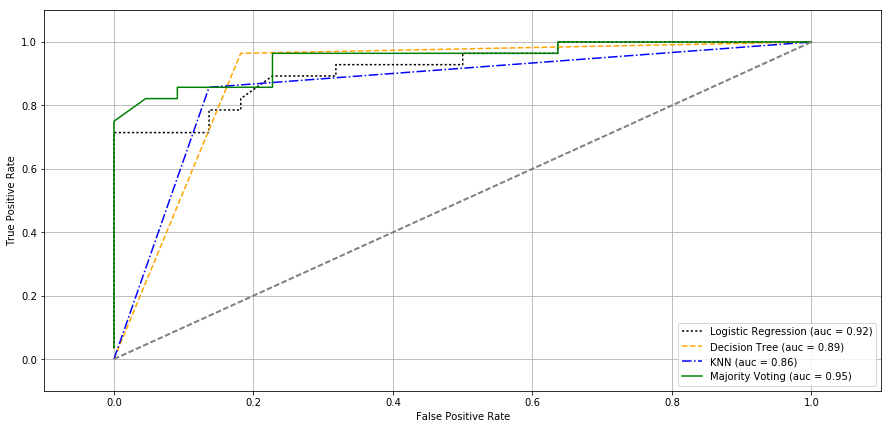

In [22]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(x_train, y_train).predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In the resulting ROC the ensemble performs well on the test set. It would be interesting to see what the decision region of the ensemble looks like.

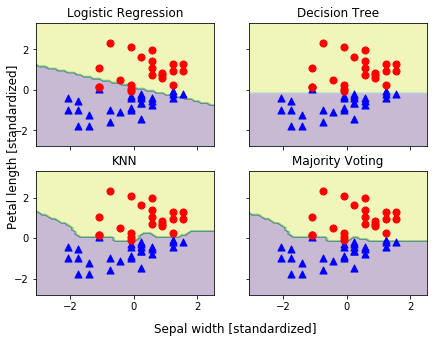

In [30]:
from itertools import product

sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = x_train_std[:, 0].min() - 1
x_max = x_train_std[:, 0].max() + 1
y_min = x_train_std[:, 1].min() - 1
y_max = x_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(
    nrows=2,
    ncols=2,
    sharex='col',
    sharey='row',
    figsize=(7, 5)
)
for idx, clf, tt in zip(product([0, 1], 
                                [0, 1]),
                                all_clf,
                                clf_labels):
    clf.fit(x_train_std, y_train)
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(x_train_std[y_train == 0, 0],
                                  x_train_std[y_train == 0, 1],
                                  c='blue',
                                  marker='^',
                                  s=50)
    axarr[idx[0], idx[1]].scatter(x_train_std[y_train == 1, 0],
                                  x_train_std[y_train == 1, 1],
                                  c='red',
                                  marker='o',
                                  s=50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5, 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)
plt.show()

Before starting to tune the ensemble classifier, let's call e **get_params** method to get an idea of how we can access the individual parameters inside a **GridSearch** objet

In [31]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_split': 1e-07,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline-1': Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_

Based on the values we got, we now know how to access every classifier's attributes. Let's tune the regularization parameter *C* of the logistic regression classifier and the decision tree depth.

In [33]:
from sklearn.grid_search import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(
    estimator=mv_clf,
    param_grid=params,
    cv=10,
    scoring='roc_auc'
)

grid.fit(x_train, y_train)

for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f+/-%0.2f %r" % (mean_score, scores.std() / 2, params))
print("Best parameters: %s" % grid.best_params_)
print("Accuracy: %.2f" % grid.best_score_)

0.967+/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}
Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Accuracy: 1.00


As we can see we get the best results when we choose a lower regularization strength (*C*=100.0) whereaa the depth of the tree seems to not affect the performance.

## Bagging